<a href="https://colab.research.google.com/github/PazMatias/TpAndroid/blob/master/HPC/Cuaderno_1_Miercoles_grupo13_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción

Como parte del desarrollo de este ejemplo practico, demostraremos la operación de traslación sobre una imagen en los ejes x e y. Pretendemos realizar el algoritmo correspondiente, en dos instancias separadas. La primera hara uso de CPU, mientras que la segunda realizara la misma operatoria valiendose del poder de computo de la GPU. De esta forma, podremos comparar la diferencia existente y la mejoria de rendimiento obtenida en la segunda instancia.

# Armado del ambiente

In [ ]:
!pip install pycuda

     |████████████████████████████████| 1.7 MB 13.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 75 kB 4.4 MB/s 
     |████████████████████████████████| 66 kB 4.4 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627661 sha256=e2acfeba77ff9a4831bfa8bc390454c64c6a88bd6e553003daaad035a804d239
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.9-py2.py3-none-any.whl size=62370 sha256=c90dcbc9165f0aca5511b3ec909200d0757f506d46d3cb95152ca1fd2ad6e6f0
  Stored in directory: /root/.cache/pip/wheels/41/b9/6e/94bb014f6484b15ec77e7877f3a227609481ffd98db364504d
Successfully built pycuda pytools


In [ ]:


url_imagen = "https://raw.githubusercontent.com/PazMatias/TpAndroid/master/HPC/tuki.jpg" #@param {type:"string"}

!wget {url_imagen} -O imagen.jpg

--2021-11-24 01:02:29--  https://raw.githubusercontent.com/PazMatias/TpAndroid/master/HPC/tuki.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106757 (104K) [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>] 104.25K  --.-KB/s    in 0.009s  

2021-11-24 01:02:29 (12.0 MB/s) - ‘imagen.jpg’ saved [106757/106757]



# Desarrollo CPU


In [ ]:
 %matplotlib inline
from datetime import datetime

tiempo_total_cpu = datetime.now()

import  matplotlib.pyplot as plt
import numpy
from PIL import Image 

desplazamiento_x = 100 #@param {type:"integer"}
desplazamiento_y = 200 #@param {type:"integer"}

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------


img_nombre = 'imagen.jpg'

image = Image.open( img_nombre ) 

  
# Optengo las proporsiones de la imagen. 
img_ancho, img_alto = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array.
img_pic_cpu = numpy.asarray(image)
img_pic_cpu = img_pic_cpu.astype( numpy.int32() )

# Genero el array resultado (3 pixeles usa RGB * (el tamaño del array)).
img_picR_cpu = numpy.empty_like( img_pic_cpu)

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

plt.figure()
imgplot=plt.imshow( img_pic_cpu )

tiempo_img_cpu = datetime.now()

# Convierto la imagen a escala de grises
for y in range( 0, img_alto ):
  for x in range( 0, img_ancho ):
    #print( x, y, img_pic_cpu[x][y] )
    dX=(x-desplazamiento_x)
    dY=(y-desplazamiento_y)
    if (dX >= 0 and dX < img_ancho and dY >= 0 and dY < img_alto):
       img_picR_cpu[y][x] = img_pic_cpu[y-desplazamiento_y][x-desplazamiento_x]
    else:
       img_picR_cpu[y][x] = 0
      

tiempo_img_cpu = datetime.now() - tiempo_img_cpu

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot = plt.imshow( img_picR_cpu )

tiempo_total_cpu = datetime.now() - tiempo_total_cpu

print( "Tiempo Total:",                   tiempo_en_ms( tiempo_total_cpu ), "[ms]" )
print( "Tiempo de conversión de imagen:", tiempo_en_ms( tiempo_img_cpu   ), "[ms]" )

Imagen del filtro: imagen.jpg -RGB- [760, 985]


# Desarrollo GPU

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: The CUDA compiler succeeded, but said the following:
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).



Imagen del filtro: imagen.jpg -RGB- [760, 985]
Thread: [ 16 , 19  ], Bloque : [ 48 , 52 ]
Total de Thread: [ 768 , 988  ]  =  758784
Tiempo TOTAL:  1179.865 [ms]
Tiempo GPU  :  1.882 [ms]


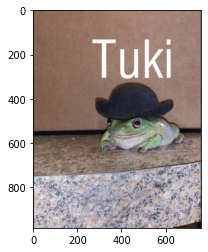

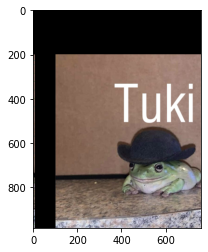

In [ ]:
%matplotlib inline
from datetime import datetime
tiempo_total_gpu = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------


desplazamiento_x = 100 #@param {type:"integer"}
desplazamiento_y = 200 #@param {type:"integer"}



img_nombre = 'imagen.jpg'
image = Image.open(img_nombre) 
  
# summarize some details about the image 
img_ancho, img_alto  = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_O_cpu = img_O_cpu.astype(numpy.int32())
img_R_cpu = numpy.empty_like(img_O_cpu)

# Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))

img_O_gpu = cuda.mem_alloc(img_O_cpu.nbytes)
img_R_gpu = cuda.mem_alloc(img_R_cpu.nbytes)

# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void kernel_translation_img(int* Source, int* Destination, int sizeX, int sizeY, int xEdge,int yEdge)
{

    int x = (blockIdx.x * blockDim.x) + threadIdx.x;// Kernel definition
    int y = (blockIdx.y * blockDim.y) + threadIdx.y;
    int idx = x + (y*sizeX);
    int newIdx = xEdge + yEdge*sizeX;
    int dx = x + xEdge;
    int dy = y + yEdge;

    if (dx >= 0 && dx < sizeX && dy >= 0 && dy < sizeY)
    {
      Destination[idx*3] = Source[(idx+ newIdx)*3]  ;
      Destination[idx*3 + 1] =Source[(idx+ newIdx)*3 + 1 ]  ;
      Destination[idx*3 + 2] = Source[(idx+ newIdx)*3 + 2 ] ;
    }
    else{
      Destination[idx*3] =0;
      Destination[idx*3 + 1] =0;
      Destination[idx*3 + 2] =0;
    }


}
""")

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_translation_img")


dim_hilo_x = 16 
dim_bloque_x = numpy.int( ((img_ancho+dim_hilo_x-1) / dim_hilo_x) )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y)

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img_gpu = datetime.now()

kernel( img_O_gpu, img_R_gpu, numpy.int32(img_ancho), numpy.int32(img_alto),numpy.int32(-desplazamiento_x),numpy.int32(-desplazamiento_y),block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )
#kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )
tiempo_img_gpu = datetime.now() - tiempo_img_gpu


# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu )

img_O_gpu.free()
img_R_gpu.free()

tiempo_total_gpu = datetime.now() - tiempo_total_gpu

print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total_gpu ), "[ms]" )
print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img_gpu ), "[ms]" )

# Metricas

## **SpeedUp**
Referencia a la ganacia de velocidad que se consigue con un algoritmo paralelo, al resolver el mismo problema con respecto al algoritmo secuencial.

$ SpeedUp = TiempoSecuencial / TiempoParalelo $

## **Eficiencia** 
La eficiencia normaliza el valor del SpeedUp, al dividirlo por la cantidad de procesadores que se utilizaron para alcanzar la ganacia en velocidad(En este caso colab usa 2 cores). Dando la idea de la porción de tiempo que los procesadores se dedican al trabajo útil.

$ Eficiencia = SpeedUp /Nro. procesadores $

In [8]:
%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()

numero_cores=2

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

dif_tiempo=tiempo_img_cpu-tiempo_img_gpu

print("Tiempo de ejecucion en CPU: ", tiempo_en_ms(tiempo_img_cpu), "[ms]")
print("Tiempo de ejecucion Total en CPU: ", tiempo_en_ms(tiempo_total_cpu), "[ms]\n")

print("Tiempo de ejecucion en GPU: ", tiempo_en_ms(tiempo_img_gpu), "[ms]")
print("Tiempo de ejecucion Total en CPU: ", tiempo_en_ms(tiempo_total_gpu), "[ms]\n")

print("Comparacion de Tiempo entre CPU y GPU: ",  tiempo_en_ms(dif_tiempo), "[ms]\n")

speedup=tiempo_en_ms(tiempo_total_cpu) / tiempo_en_ms(tiempo_total_gpu)
print("Speedup: {:.2f}".format(speedup), "[ms]" )
print("Eficiencia: {:.2f}".format(speedup/numero_cores), "[ms]\n")

Tiempo de ejecucion en CPU:  1098.876 [ms]
Tiempo de ejecucion Total en CPU:  1229.152 [ms]

Tiempo de ejecucion en GPU:  2.108 [ms]
Tiempo de ejecucion Total en CPU:  1161.555 [ms]

Comparacion de Tiempo entre CPU y GPU:  1096.768 [ms]

Speedup: 1.06 [ms]
Eficiencia: 0.53 [ms]



# Conclusiones

Luego de haber trabajado con el ejemplo practico asignado(traslación de imagen) pudimos cumplir con la premisa planteada en el trabajo práctico identificando una mejora en cuanto a rendimiento por parte de la implementación con GPU usando el modulo de CUDA sobre la implementación con CPU de manera secuencial. A pesar de que nuestro algoritmo aplica una logica muy básica, evidentemente si nos enfocamos en los tiempos resultantes obtenidos en la sección anterior de métricas por parte de las dos implementaciones, podemos percibir una amplia diferencia denotando que haciendo uso de threads paralelizados mejora exponencialmente el rendimiento.

# Bibliografia

[1] Metricas para comparar trabajo secuencial y paralelo [[Metricas]](https://github.com/wvaliente/SOA_HPC/blob/main/Ejercicios/Prueba%201%20-%20Vectores%20-%20OpenMP.ipynb)

[2] GPU Accelerated Real Time Rotation, Scale and Translation Invariant Image Registration Method [[Paper]](https://www.researchgate.net/publication/230899846_GPU_Accelerated_Real_Time_Rotation_Scale_and_Translation_Invariant_Image_Registration_Method)

[3] CUDA Image Rotation [[StackOverflow]](https://stackoverflow.com/questions/9833316/cuda-image-rotation)